In [23]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import cv2

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import sklearn.metrics as metrics

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

In [25]:
train = pd.read_csv("../data/emnist/archive/emnist-balanced-train.csv")
test = pd.read_csv("../data/emnist/archive/emnist-balanced-test.csv")
print(train.shape,test.shape)
mapp = pd.read_csv("../data/emnist/archive/emnist-balanced-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train.shape, test.shape, mapp.shape))

(112799, 785) (18799, 785)
Train: (112799, 785), Test: (18799, 785), Map: (47,)


/tmp/ipykernel_6624/521008479.py:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  mapp = pd.read_csv("../data/emnist/archive/emnist-balanced-mapping.txt", delimiter = ' ', \


In [5]:
train.head(10)

,45,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.524,0.525,0.526,0.527,0.528,0.529,0.530,0.531,0.532,0.533
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,46,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Constants
HEIGHT = 28
WIDTH = 28

In [27]:
# Split x and y
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
del train

test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]
del test

In [28]:
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(112799, 784) (112799,) (18799, 784) (18799,)


In [29]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [30]:
# Flip and rotate image
train_x = np.asarray(train_x)
train_x = np.apply_along_axis(rotate, 1, train_x)
print ("train_x:",train_x.shape)

test_x = np.asarray(test_x)
test_x = np.apply_along_axis(rotate, 1, test_x)
print ("test_x:",test_x.shape)

train_x: (112799, 28, 28)
test_x: (18799, 28, 28)


In [31]:
# Normalise
train_x = train_x.astype('float32')
train_x /= 255
test_x = test_x.astype('float32')
test_x /= 255


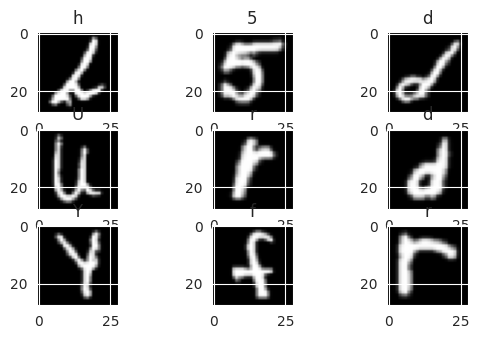

In [32]:
# plot image
for i in range(100, 109):
    plt.subplot(330 + (i+1))
    plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
    plt.title(chr(mapp[train_y[i]]))

In [33]:
# number of classes
num_classes = train_y.nunique()

In [34]:
print(num_classes)

47


this is to one hot encoding - so if char is a : then for a it will be a->1 and others 0.  E.g. for use with categorical_crossentropy

In [35]:
# One hot encoding
train_y = np_utils.to_categorical(train_y, num_classes)
test_y = np_utils.to_categorical(test_y, num_classes)
print("train_y: ", train_y.shape)
print("test_y: ", test_y.shape)

train_y:  (112799, 47)
test_y:  (18799, 47)


In [36]:
# Reshape image for CNN
train_x = train_x.reshape(-1, HEIGHT, WIDTH, 1)
test_x = test_x.reshape(-1, HEIGHT, WIDTH, 1)

In [37]:
print("train: ",train_x.shape,"test: ",test_x.shape )

train:  (112799, 28, 28, 1) test:  (18799, 28, 28, 1)


In [38]:
# partition to train and val
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size= 0.20, random_state=7)

In [39]:
# Building model
# ((Si - Fi + 2P)/S) + 1
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(5,5), padding = 'same', activation='relu',\
                 input_shape=(HEIGHT, WIDTH,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3) , padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [44]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
MCP = ModelCheckpoint('Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

In [46]:
history = model.fit(train_x, train_y, epochs=5, batch_size=512, verbose=1, \
                    validation_data=(val_x, val_y),callbacks=[MCP,ES,RLP])

Epoch 1/5
177/177 [==============================] - ETA: 0s - loss: 1.7199 - accuracy: 0.5130
Epoch 1: val_accuracy improved from -inf to 0.80559, saving model to Best_points.h5
177/177 [==============================] - 75s 421ms/step - loss: 1.7199 - accuracy: 0.5130 - val_loss: 0.6125 - val_accuracy: 0.8056 - lr: 0.0010
Epoch 2/5
177/177 [==============================] - ETA: 0s - loss: 0.8328 - accuracy: 0.7371
Epoch 2: val_accuracy improved from 0.80559 to 0.83617, saving model to Best_points.h5
177/177 [==============================] - 72s 409ms/step - loss: 0.8328 - accuracy: 0.7371 - val_loss: 0.4854 - val_accuracy: 0.8362 - lr: 0.0010
Epoch 3/5
177/177 [==============================] - ETA: 0s - loss: 0.6801 - accuracy: 0.7821
Epoch 3: val_accuracy improved from 0.83617 to 0.85040, saving model to Best_points.h5
177/177 [==============================] - 78s 439ms/step - loss: 0.6801 - accuracy: 0.7821 - val_loss: 0.4321 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 4/5
177/17

In [22]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc,title):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel(title)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [47]:
model.save('../models/model_char_degit.h5')

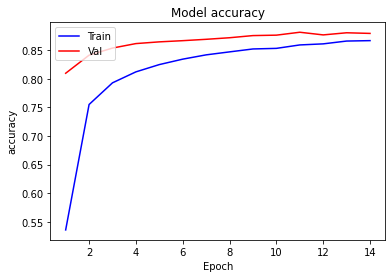

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

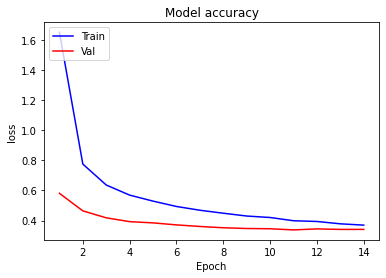

In [25]:
# Accuracy curve
plotgraph(epochs, acc, val_acc,"accuracy")

In [26]:
# loss curve
plotgraph(epochs, loss, val_loss,"loss")

Test loss: 0.35938403010368347
Test accuracy: 0.8769615292549133


In [ ]:
score = model.evaluate(test_x, test_y, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])